In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
from google.colab import files  
uploaded = files.upload()

Saving train.csv to train.csv


In [3]:
import pandas as pd
import io
  
train_csv = pd.read_csv(io.BytesIO(uploaded['train.csv']))
train_csv.head()

,time,value
0,0,52.483570
1,1,49.352749
2,2,53.314735
3,3,57.711823
4,4,48.934444


In [4]:
from google.colab import files  
uploaded = files.upload()

Saving test.csv to test.csv


In [5]:
import pandas as pd
import io
  
val_csv = pd.read_csv(io.BytesIO(uploaded['test.csv']))
val_csv.head()

,time,value
0,1000,71.344719
1,1001,68.985519
2,1002,64.675201
3,1003,61.157360
4,1004,67.898438


In [6]:
def normalize(data):
    data_mean = data[:].mean(axis=0)
    data_std = data[:].std(axis=0)
    return (data - data_mean) / data_std


features = normalize(train_csv.values)
train_data = pd.DataFrame(features)


features = normalize(val_csv.values)
val_data = pd.DataFrame(features)

In [7]:
past = 20
future = 1

start = past + future
x_end = len(train_data) - past - future
print(x_end)
x_train = train_data[:x_end][[i for i in range(1)]].values
y_train = train_data.iloc[start:][[1]]

print(x_train.shape)
# print(x_train)
print(y_train.shape)
# print(y_train)


x_end = len(val_data) - past - future
print(x_end)
x_val = val_data[:x_end][[i for i in range(1)]].values
y_val = val_data.iloc[start:][[1]]


print(x_val.shape)
# print(x_train)
print(y_val.shape)
# print(y_train)

979
(979, 1)
(979, 1)
440
(440, 1)
(440, 1)


In [8]:
batch_size = 1
step = 1
sequence_length = int(past / step)

dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)


for batch in dataset_train.take(2):
    inputs, targets = batch

    print("Input shape:", inputs.numpy().shape)
    print("Target shape:", targets.numpy().shape)

Input shape: (1, 20, 1)
Target shape: (1, 1)
Input shape: (1, 20, 1)
Target shape: (1, 1)


In [ ]:
learning_rate = 0.0001
epochs = 100

inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
rnn_1 = keras.layers.SimpleRNN(units=128 ,return_sequences=True)(inputs)
rnn_2 = keras.layers.SimpleRNN(units=64)(rnn_1)
fully_1 = keras.layers.Dense(units=32 ,activation='elu')(rnn_2)
drop_out = keras.layers.Dropout(0.5)(fully_1)
outputs = keras.layers.Dense(1)(drop_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mae")
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20, 1)]           0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 20, 128)           16640     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 64)                12352     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 31,105
Trainable params: 31,105
Non-trainable params: 0
_________________________________________________________

In [ ]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=20)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/100
960/960 [==============================] - 45s 42ms/step - loss: 0.5241 - val_loss: 0.8851

Epoch 00001: val_loss improved from inf to 0.88509, saving model to model_checkpoint.h5
Epoch 2/100
960/960 [==============================] - 41s 42ms/step - loss: 0.5235 - val_loss: 0.7026

Epoch 00002: val_loss improved from 0.88509 to 0.70259, saving model to model_checkpoint.h5
Epoch 3/100
960/960 [==============================] - 41s 43ms/step - loss: 0.5318 - val_loss: 0.8565

Epoch 00003: val_loss did not improve from 0.70259
Epoch 4/100
960/960 [==============================] - 41s 43ms/step - loss: 0.5105 - val_loss: 0.9582

Epoch 00004: val_loss did not improve from 0.70259
Epoch 5/100
960/960 [==============================] - 41s 43ms/step - loss: 0.5198 - val_loss: 0.8782

Epoch 00005: val_loss did not improve from 0.70259
Epoch 6/100
960/960 [==============================] - 41s 43ms/step - loss: 0.5607 - val_loss: 0.7959

Epoch 00006: val_loss did not improve from 

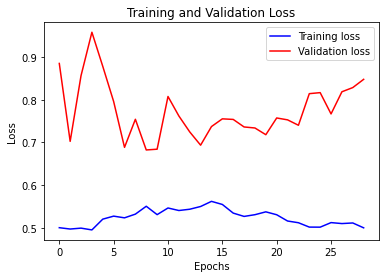

In [ ]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

In [ ]:
y_true=[]
y_pred=[]
for x, y in dataset_val:
    y_true.append(float(y[0]))
    y_pred.append(float(model.predict(x)[0]))

print(len(y_true))

421


421


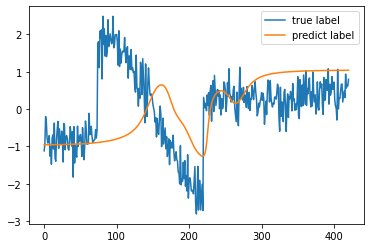

In [ ]:
print(len(y_true))
plt.plot(y_true, label='true label')
plt.plot(y_pred, label='predict label')
plt.legend()